# k-scheduling tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, ModifiedIterativeAmplitudeEstimation
from algorithms import NoQuantumIterativeAmplitudeEstimation
from operators import *

In [2]:
# for setting a single amplitude, below automates this for arbirtrary numbers of amplitudes
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def make_problems(n, marked):
    
    def good_state(state):
        bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
        return (state in bin_marked)

    problem = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    problem2 = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    
    return problem, problem2

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 512

## IQAE: attempt exponential decay in the number of shots per iteration to account for deeper circuits.

In [5]:
# parameters for IQAE

# amplitudes
n = 4
k = 2**n

# epsilons
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]

# other
alpha = 0.05
confint_method = 'chernoff'
verbose = True

ε: 0.01
T: 7

  k_i: 0
round_shots: 512
prob current:  1.0
ampls: [0.8182959952805943, 1.0]

  k_i: 1
round_shots: 512
prob current:  1.0
ampls: [0.9786077249652415, 1.0]

  k_i: 4
round_shots: 512
prob current:  1.0
ampls: [0.9976078451411614, 1.0]

  k_i: 15
round_shots: 512
prob current:  1.0
ampls: [0.999798224554963, 1.0]


ε: 0.001
T: 10

  k_i: 0
round_shots: 512
prob current:  1.0
ampls: [0.8126334139161658, 1.0]

  k_i: 1
round_shots: 512
prob current:  1.0
ampls: [0.9778980252290668, 1.0]

  k_i: 4
round_shots: 512
prob current:  1.0
ampls: [0.9975279558760128, 1.0]

  k_i: 15
round_shots: 512
prob current:  1.0
ampls: [0.9997914808956594, 1.0]

  k_i: 53
round_shots: 512
prob current:  1.0
ampls: [0.9999824963210997, 1.0]

  k_i: 187
round_shots: 512
prob current:  1.0
ampls: [0.9999985749283998, 1.0]


ε: 0.0001
T: 13

  k_i: 0
round_shots: 512
prob current:  1.0
ampls: [0.8085750063528145, 1.0]

  k_i: 1
round_shots: 512
prob current:  1.0
ampls: [0.9773875881762824, 1.0]


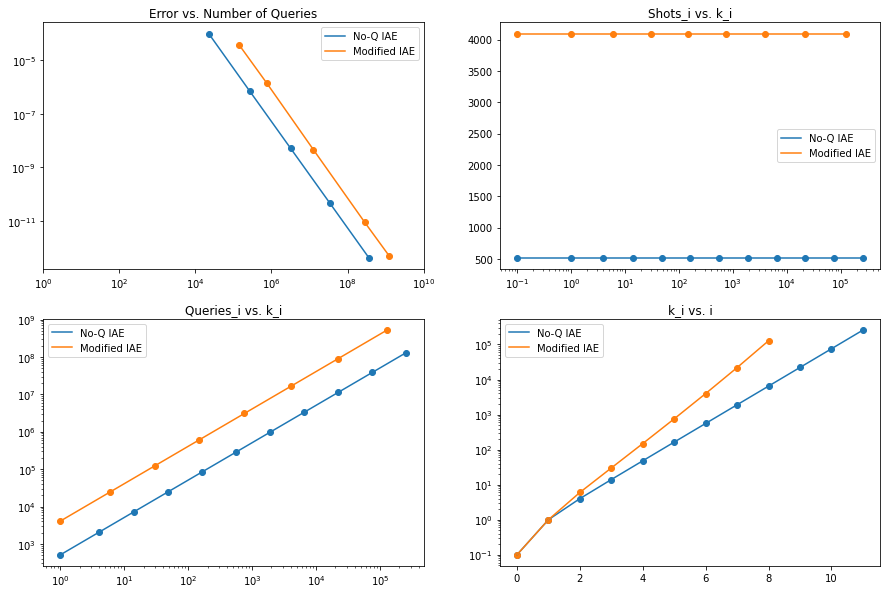

ε: 0.01
T: 7

  k_i: 0
round_shots: 512
prob current:  0.943359375
ampls: [0.7616553702805943, 1.0]

  k_i: 1
round_shots: 512
prob current:  0.56640625
ampls: [0.9123394746265209, 0.9695973535145844]

  k_i: 4
round_shots: 512
prob current:  0.39453125
ampls: [0.9286984069676552, 0.9489940827819541]

  k_i: 14
round_shots: 512
prob current:  0.24609375
ampls: [0.932922280308613, 0.9405802085440276]


ε: 0.001
T: 10

  k_i: 0
round_shots: 512
prob current:  0.94921875
ampls: [0.761852163916166, 1.0]

  k_i: 1
round_shots: 512
prob current:  0.5625
ampls: [0.910472108944763, 0.9698287463869194]

  k_i: 4
round_shots: 512
prob current:  0.4140625
ampls: [0.9272273259732803, 0.9481721465147924]

  k_i: 11
round_shots: 512
prob current:  0.806640625
ampls: [0.9289505507974766, 0.9415092630643903]

  k_i: 11
round_shots: 1024
prob current:  0.7900390625
ampls: [0.9334525780024625, 0.9406935025829762]

  k_i: 38
round_shots: 512
prob current:  0.673828125
ampls: [0.9362866742695363, 0.938907

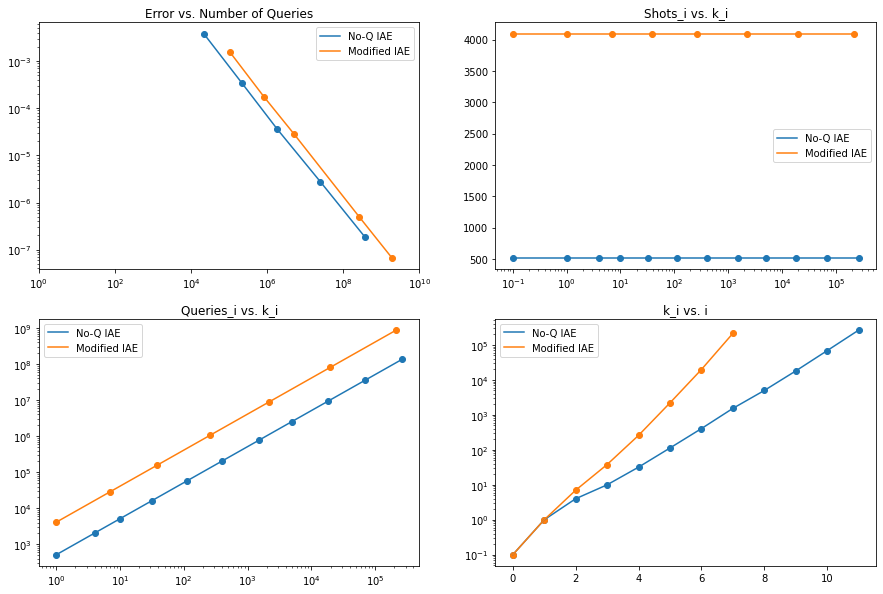

ε: 0.01
T: 7

  k_i: 0
round_shots: 512
prob current:  0.87109375
ampls: [0.6893897452805942, 1.0]

  k_i: 0
round_shots: 1024
prob current:  0.865234375
ampls: [0.7367502410941559, 0.9937185089058441]

  k_i: 0
round_shots: 1536
prob current:  0.8626302083333334
ampls: [0.7577233522957514, 0.9675370643709154]

  k_i: 1
round_shots: 512
prob current:  0.21484375
ampls: [0.8008554525438601, 0.9146147183623882]

  k_i: 1
round_shots: 1024
prob current:  0.2041015625
ampls: [0.8256573350031581, 0.9018209266965563]

  k_i: 3
round_shots: 512
prob current:  0.705078125
ampls: [0.8485154749149645, 0.888824341701355]

  k_i: 9
round_shots: 512
prob current:  0.701171875
ampls: [0.8685553169773604, 0.8830145213358406]

  k_i: 31
round_shots: 512
prob current:  0.529296875
ampls: [0.8732594673083337, 0.8771694363957608]


ε: 0.001
T: 10

  k_i: 0
round_shots: 512
prob current:  0.865234375
ampls: [0.6778677889161658, 1.0]

  k_i: 0
round_shots: 1024
prob current:  0.8759765625
ampls: [0.7434883

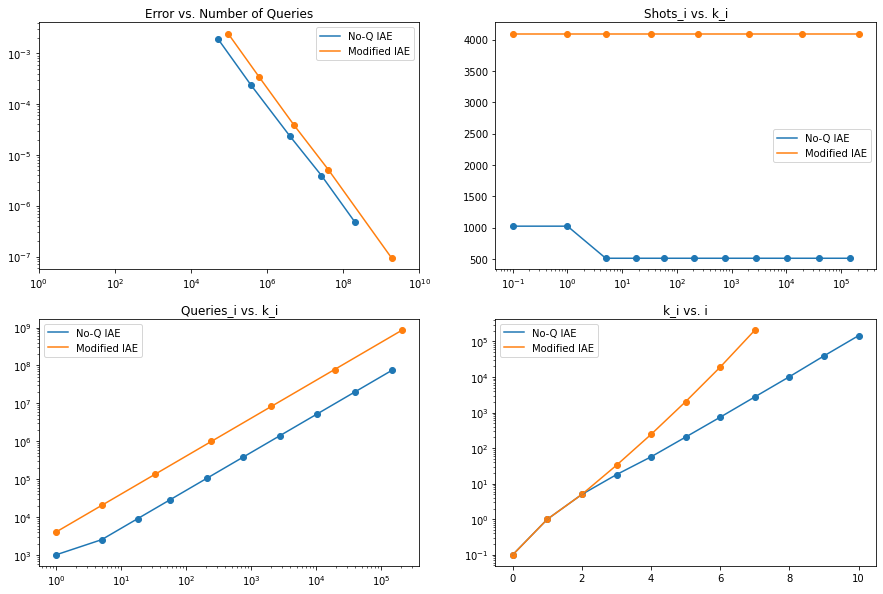

ε: 0.01
T: 7

  k_i: 0
round_shots: 512
prob current:  0.8359375
ampls: [0.6542334952805942, 1.0]

  k_i: 0
round_shots: 1024
prob current:  0.830078125
ampls: [0.7015939910941557, 0.9585622589058442]

  k_i: 0
round_shots: 1536
prob current:  0.8274739583333334
ampls: [0.7225671022957513, 0.9323808143709152]

  k_i: 0
round_shots: 2048
prob current:  0.8271484375
ampls: [0.736296435140297, 0.9180004398597028]

  k_i: 0
round_shots: 2560
prob current:  0.82265625
ampls: [0.7413957487326932, 0.9039167512673066]

  k_i: 2
round_shots: 512
prob current:  0.37109375
ampls: [0.7852686692375043, 0.8453217147069755]

  k_i: 6
round_shots: 512
prob current:  0.783203125
ampls: [0.7958410822031591, 0.8256355898561135]

  k_i: 16
round_shots: 512
prob current:  0.37109375
ampls: [0.8078179265410238, 0.8169983799559282]


ε: 0.001
T: 10

  k_i: 0
round_shots: 512
prob current:  0.8046875
ampls: [0.6173209139161658, 0.9920540860838343]

  k_i: 0
round_shots: 1024
prob current:  0.8076171875
ampls:

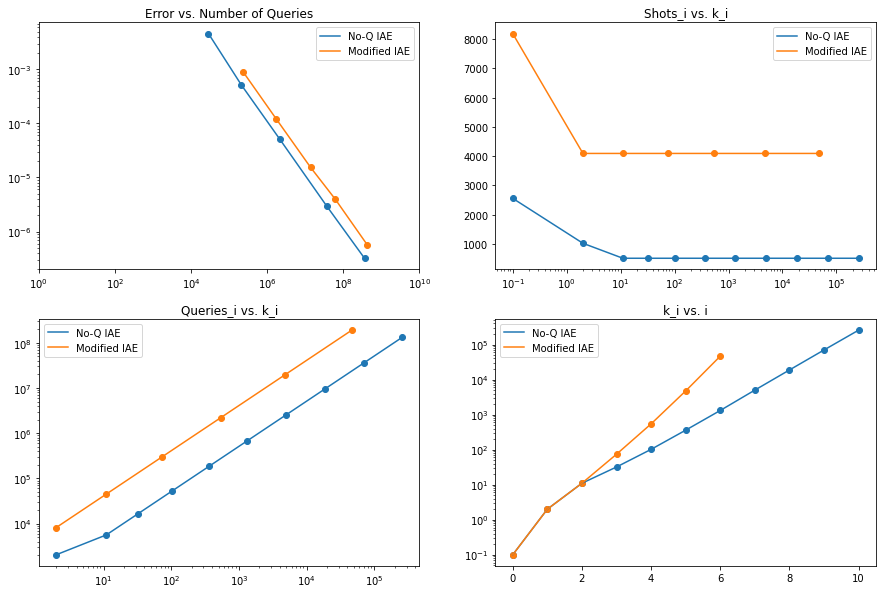

ε: 0.01
T: 7

  k_i: 0
round_shots: 512
prob current:  0.751953125
ampls: [0.5702491202805943, 0.9336571297194057]

  k_i: 0
round_shots: 1024
prob current:  0.7392578125
ampls: [0.6107736785941558, 0.8677419464058441]

  k_i: 0
round_shots: 1536
prob current:  0.7486979166666666
ampls: [0.6437910606290849, 0.8536047727042485]

  k_i: 0
round_shots: 2048
prob current:  0.74951171875
ampls: [0.6586597163902971, 0.8403637211097027]

  k_i: 2
round_shots: 512
prob current:  0.7578125
ampls: [0.7009324398638123, 0.7813946353884212]

  k_i: 6
round_shots: 512
prob current:  0.744140625
ampls: [0.7366145579436199, 0.7663221815207992]

  k_i: 14
round_shots: 512
prob current:  0.75
ampls: [0.7422201834634927, 0.7557498026008694]


ε: 0.001
T: 10

  k_i: 0
round_shots: 512
prob current:  0.759765625
ampls: [0.5723990389161658, 0.9471322110838342]

  k_i: 0
round_shots: 1024
prob current:  0.75
ampls: [0.6175118164123479, 0.882488183587652]

  k_i: 0
round_shots: 1536
prob current:  0.747395833

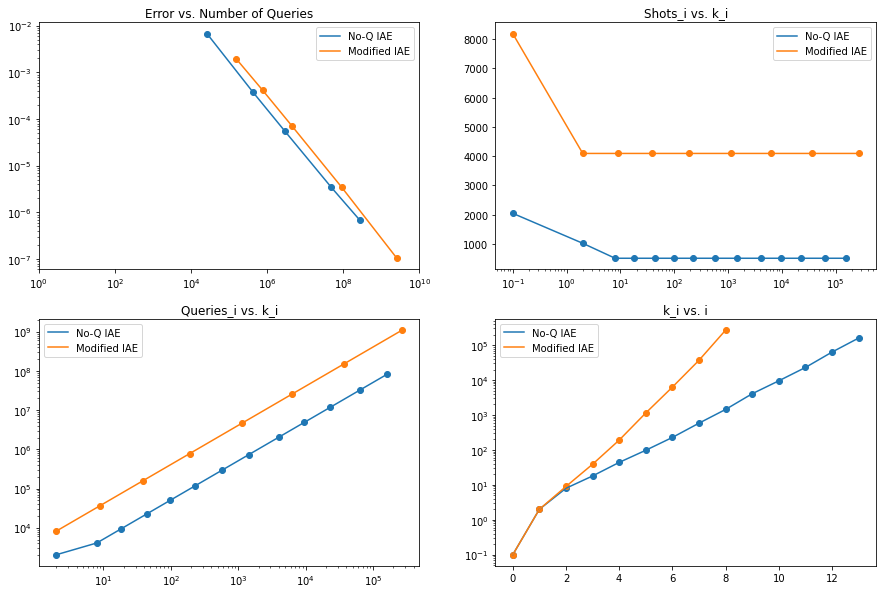

ε: 0.01
T: 7

  k_i: 0
round_shots: 512
prob current:  0.701171875
ampls: [0.5194678702805942, 0.8828758797194056]

  k_i: 0
round_shots: 1024
prob current:  0.6806640625
ampls: [0.5521799285941557, 0.8091481964058442]

  k_i: 0
round_shots: 1536
prob current:  0.6796875
ampls: [0.5747806439624181, 0.7845943560375819]

  k_i: 0
round_shots: 2048
prob current:  0.68017578125
ampls: [0.5893237788902971, 0.7710277836097028]

  k_i: 0
round_shots: 2560
prob current:  0.675390625
ampls: [0.5941301237326931, 0.7566511262673068]

  k_i: 0
round_shots: 3072
prob current:  0.6780598958333334
ampls: [0.603879546536198, 0.7522402451304683]

  k_i: 0
round_shots: 3584
prob current:  0.6838727678571429
ampls: [0.6151951094697066, 0.752550426244579]

  k_i: 3
round_shots: 512
prob current:  0.26171875
ampls: [0.6507844254885182, 0.7096160454429874]

  k_i: 8
round_shots: 512
prob current:  0.603515625
ampls: [0.676306780372851, 0.6971506388474887]

  k_i: 28
round_shots: 512
prob current:  0.5566406

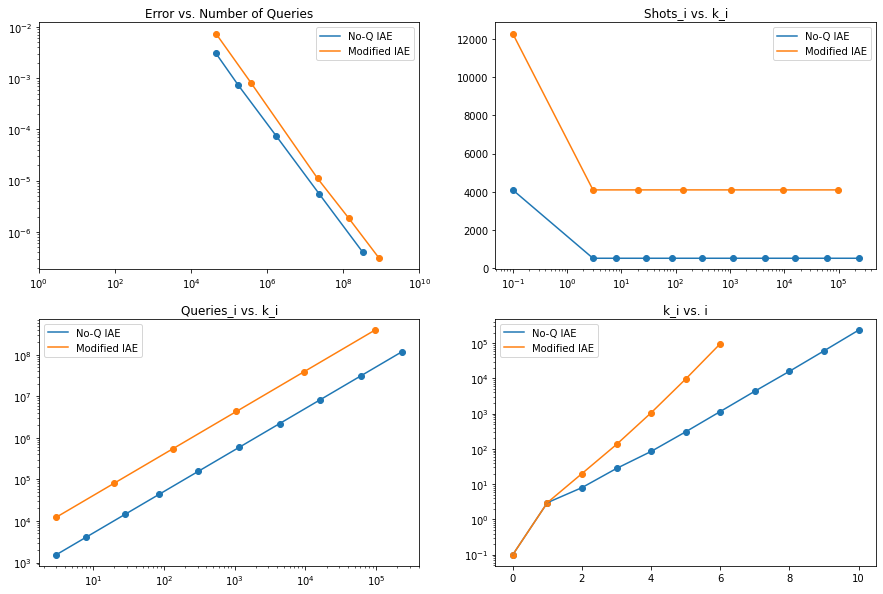

ε: 0.01
T: 7

  k_i: 0
round_shots: 512
prob current:  0.623046875
ampls: [0.44134287028059416, 0.8047508797194057]

  k_i: 0
round_shots: 1024
prob current:  0.6064453125
ampls: [0.47796117859415566, 0.7349294464058443]

  k_i: 1
round_shots: 512
prob current:  0.12890625
ampls: [0.5645653987085113, 0.7499999999999999]

  k_i: 1
round_shots: 1024
prob current:  0.1494140625
ampls: [0.5764135685791796, 0.7906747549980736]

  k_i: 1
round_shots: 1536
prob current:  0.14583333333333334
ampls: [0.5865436421800536, 0.8063232365839951]

  k_i: 1
round_shots: 2048
prob current:  0.1484375
ampls: [0.5909107279580954, 0.816396620022416]

  k_i: 1
round_shots: 2560
prob current:  0.1453125
ampls: [0.5958369183744565, 0.8198766526037848]

  k_i: 1
round_shots: 3072
prob current:  0.146484375
ampls: [0.598155360401632, 0.8240531661705673]

  k_i: 1
round_shots: 3584
prob current:  0.14425223214285715
ampls: [0.6012211493623567, 0.8256368323469819]

  k_i: 1
round_shots: 4096
prob current:  0.1457

KeyboardInterrupt: 

In [6]:
# stats recording
iae_epsilon = []
iae_nshots = []
miae_epsilon = []
miae_nshots = []

wins = matches = 0

while k >= 1:
    
    # setup problems with specified N,k
    N = 2**n
    marked = sample(range(N), k)
    problem, problem2 = make_problems(n, marked)
    
    # execute experiments for each power
    miae_results = [] 
    iae_results = []
    
    for i, epsilon in enumerate(epsilons):
        if verbose:
            print('ε:',epsilon)
            
        MIAE = NoQuantumIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                           alpha=alpha, 
                                           confint_method=confint_method, 
                                           quantum_instance=aer_sim)
        
        IAE = ModifiedIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                alpha=alpha, 
                                                confint_method=confint_method, 
                                                quantum_instance=aer_sim)
        
        exprs = ['No-Q IAE', 'Modified IAE']
        
        # configure the number of shots this way and pray that it works
        MIAE._quantum_instance._run_config.shots = shots
        IAE._quantum_instance._run_config.shots = 4096
        
        # for recording intermediate algo results
        state = defaultdict(dict)
        state2 = defaultdict(dict)
        
        miae_result = MIAE.estimate(problem,
                                    state=state,
                                    k0=k,
                                    N=N,
                                    verbose=verbose)
        
        iae_result = IAE.estimate(problem2,
                                  state=state2,
                                  verbose=False)
        
        miae_results.append(miae_result)
        iae_results.append(iae_result)
        if verbose:
            print()
    
    # process results
    miae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in miae_results]
    miae_nshots_i  = [res.num_oracle_queries for res in miae_results]

    iae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in iae_results]
    iae_nshots_i  = [res.num_oracle_queries for res in iae_results]
    
    print(f'a: {k}/{N} = {k/N}')
    print(f'{exprs[0]} estimations:', [res.estimation for res in miae_results])
    print(f'{exprs[1]} estimations:', [res.estimation for res in iae_results])
    
    miae_total_queries, iae_total_queries = sum(miae_nshots_i), sum(iae_nshots_i)
    print(f'{exprs[0]} total queries:', miae_total_queries)
    print(f'{exprs[1]} total queries:' , iae_total_queries)
    
    diff = round(abs(iae_total_queries - miae_total_queries) / miae_total_queries * 100, 2)
    print('Modified wins?', iae_total_queries < miae_total_queries, f'with {diff}% difference')
    
    wins += int(iae_total_queries < miae_total_queries)
    matches += 1
    
    # graph k_i vs num_shots
    def process_state(state):
        if len(state) == 0: return [],[]
        round_shots = state['round_shots']
        queries = state['n_queries']
        shots_at_k0 = round_shots.pop(0)
        queries_at_k0 = queries.pop(0)
    
        k_i = [k for k in round_shots]
        queries_i = [queries[k] for k in k_i]
        shots_i = [shots_at_k0] + [round_shots[k] for k in k_i]
    
        k_i.insert(0, 0.1)
        
        return shots_i, queries_i, k_i
    
    mod_shots, mod_queries, mod_k = process_state(state)
    base_shots, base_queries, base_k = process_state(state2)

    fig,axs = plt.subplots(2,2,figsize=(15,10))
    
    # plot query complexity
    
    axs[0,0].set_yscale('log')
    axs[0,0].set_xscale('log')
    axs[0,0].set_xlim(1, 10**10)
    axs[0,0].set_title('Error vs. Number of Queries')
    
    axs[0,0].scatter(miae_nshots_i, miae_epsilon_i)
    axs[0,0].plot(miae_nshots_i, miae_epsilon_i)
    axs[0,0].scatter(iae_nshots_i, iae_epsilon_i)
    axs[0,0].plot(iae_nshots_i, iae_epsilon_i)
    
    axs[0,0].legend(exprs)
    
    # plots for shots vs k
    axs[0,1].set_xscale('log')
    axs[0,1].set_title('Shots_i vs. k_i')
    
    axs[0,1].plot(mod_k, mod_shots)
    axs[0,1].scatter(mod_k, mod_shots)
    axs[0,1].plot(base_k, base_shots)
    axs[0,1].scatter(base_k, base_shots)
    
    axs[0,1].legend(exprs)
    
    # plots for nqueries vs k
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('Queries_i vs. k_i')
    
    axs[1,0].plot(mod_k[1:], mod_queries)
    axs[1,0].scatter(mod_k[1:], mod_queries)
    axs[1,0].plot(base_k[1:], base_queries)
    axs[1,0].scatter(base_k[1:], base_queries)
    
    axs[1,0].legend(exprs)
    
    # plots for k
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('k_i vs. i')
    
    axs[1,1].plot(mod_k)
    axs[1,1].scatter(range(len(mod_k)), mod_k)
    axs[1,1].plot(base_k)
    axs[1,1].scatter(range(len(base_k)), base_k)
    
    axs[1,1].legend(exprs)
    
    plt.show()
    
    # save results for epsilon vs nshots
    miae_nshots.append(miae_nshots_i)
    miae_epsilon.append(miae_epsilon_i)
    iae_nshots.append(iae_nshots_i)
    iae_epsilon.append(iae_epsilon_i)
    k -= 1
    
iae_nshots = np.array(iae_nshots)
print('% modified > original:', wins/matches)

In [ ]:
for i in range(len(epsilons)):
    plt.plot(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])
    plt.scatter(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])

plt.title('Number of queries vs. 1/Input amplitude')
plt.legend(['{:.0e}'.format(eps) for eps in epsilons])
plt.xscale('log')
plt.yscale('log')

plt.show()